In [1]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.wait import WebDriverWait
from time import sleep
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import config

In [ ]:
# disable notifications
chrome_options = Options()
chrome_options.add_argument("--disable-notifications")

In [ ]:
# open facebook
driver = webdriver.Chrome(config.path_to_chromedriver, options=chrome_options) 
driver.get("https://www.facebook.com")

In [ ]:
# Log in using my credentials
username = WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[name='email']")))
password = WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[name='pass']")))

# my_username and my_password should be replaced with your own unique values
username.clear()
username.send_keys(config.my_username)
password.clear()
password.send_keys(config.my_password)
button = WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button[type='submit']"))).click()
sleep(8)

In [ ]:
# Open the facebook group (Student Housing in Waterloo)
driver.get('https://www.facebook.com/groups/110354088989367')
sleep(10)

In [ ]:
# scroll down to gather more posts
for j in range(0,40):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    sleep(10)

In [ ]:
# store all posts' html in all_posts
soup = BeautifulSoup(driver.page_source, "html.parser")
all_posts = soup.find_all('div', attrs={'class':'du4w35lb k4urcfbm l9j0dhe7 sjgh65i0'})

In [ ]:
len(all_posts) # note: 282 posts when scrolled 50 times - range(0, 50)

In [ ]:
# This function takes in the message from each post, and returns the number of bedrooms specified
def get_bedrooms(my_str):
    d1 = re.search('([^ \r\n]+) beds?', my_str, re.IGNORECASE)
    d2 = re.search('([^ \r\n]+) bedrooms?', my_str, re.IGNORECASE)
    if d1:
        beds = d1.group(0)
    elif d2:
        beds = d2.group(0)
    else:
        beds = 1 # one bedroom by default if not specified
    return beds

In [ ]:
# testing get_bedrooms: 
msg = '2 Beds 1 Bath - Apartment203 Albert St, Waterloo, ON N2L 3T4, Canada'
print('bedroom:', get_bedrooms(msg))

In [ ]:
# This function takes in the message from each post, and returns a Boolean value to indicate whether the post is
#   looking for a housing (True), or is in search for a housing (False)
def is_looking(my_str):
    my_str = my_str.lower()
    if 'looking'in my_str:
        return True
    elif 'available' or 'offering' in my_str:
        return False
    else:
        return None

In [ ]:
# initializes lists to be added to the dataframe later on
price_list = []
bedrooms_list = []
isLookingFor_list = []

In [ ]:
for post in all_posts: 
    price_text = post.find('span', attrs={'class': 'sqxagodl'}).find('div').getText()
    try: 
        price = ''.join([n for n in price_text.split()[0] if n.isdigit()])
        if price == '':
            price = 0
    except: 
        price = 0
    
    message_text = post.find('div', attrs={'data-ad-comet-preview':'message'})
    try:
        message = str(message_text.getText())
    except:
        message = ''

    bedroom_text = get_bedrooms(message)
    try: 
        bedroom = ''.join([n for n in str(bedroom_text).split()[0] if n.isdigit()])
        if bedroom == '':
            bedroom = 1
    except:
        bedroom = 1 # 1 bedroom by default if not specified

    if int(price) >= 1600: # if price is above 1600, assume that it's total price for the entire unit
        price = int(price) // int(bedroom)

    price_list.append(int(price))
    bedrooms_list.append(int(bedroom))
    isLookingFor_list.append(is_looking(message))

In [ ]:
price_list[:10], bedrooms_list[:10], isLookingFor_list[:10]

In [ ]:
len(price_list), len(bedrooms_list)

In [ ]:
data = {'price': price_list, 'bedroom': bedrooms_list, 'isLookingFor': isLookingFor_list}

In [ ]:
# df = pd.DataFrame(data)
# df.to_excel('housing_list.xlsx', index=False)
df.head()

#### For convenience, I am reading from the excel file to analyze data instead of scraping from facebook each time

In [2]:
df = pd.read_excel('housing_list.xlsx')

In [3]:
# ignore some rows (since people might be either putting numbers like $1, $100, $123456, $999999, or might be looking for a parking spot)
df.drop(df[(df.price < 300) | (df.price > 2000)].index, inplace=True)
df.drop(df[df.bedroom > 7].index, inplace=True) # assume there are no more bedrooms than 7

In [4]:
df.groupby('isLookingFor').describe()

price                                                       \
             count        mean         std    min    25%    50%     75%   
isLookingFor                                                              
False         53.0  928.377358  341.732139  300.0  700.0  900.0  1200.0   
True          86.0  959.523256  361.304555  300.0  800.0  837.5  1000.0   

                     bedroom                                               
                 max   count      mean       std  min  25%  50%  75%  max  
isLookingFor                                                               
False         1950.0    53.0  1.283019  0.743623  1.0  1.0  1.0  1.0  5.0  
True          2000.0    86.0  1.267442  0.758085  1.0  1.0  1.0  1.0  5.0

In [5]:
df.groupby('isLookingFor').get_group(True).groupby('bedroom').describe()

price                                                        
        count   mean         std    min    25%    50%     75%     max
bedroom                                                              
1        72.0  971.5  384.909355  300.0  787.5  825.0  1000.0  2000.0
2        10.0  965.0  187.157094  700.0  812.5  975.0  1037.5  1300.0
3         1.0  566.0         NaN  566.0  566.0  566.0   566.0   566.0
4         1.0  825.0         NaN  825.0  825.0  825.0   825.0   825.0
5         2.0  765.0   49.497475  730.0  747.5  765.0   782.5   800.0

In [6]:
df.groupby('isLookingFor').get_group(False).groupby('bedroom').describe()

price                                                                
        count         mean         std    min     25%     50%     75%     max
bedroom                                                                      
1        43.0   903.488372  354.853918  300.0  700.00   800.0  1000.0  1950.0
2         8.0  1109.875000  242.917057  700.0  969.75  1150.0  1300.0  1400.0
4         1.0   800.000000         NaN  800.0  800.00   800.0   800.0   800.0
5         1.0   675.000000         NaN  675.0  675.00   675.0   675.0   675.0

In [7]:
# by_bedroom = df.groupby('bedroom')
df.groupby('bedroom').describe()

price                                                           \
         count         mean         std    min     25%     50%      75%   
bedroom                                                                   
1        115.0   946.069565  373.840235  300.0  750.00   800.0  1000.00   
2         18.0  1029.388889  219.838748  700.0  857.25  1000.0  1237.50   
3          1.0   566.000000         NaN  566.0  566.00   566.0   566.00   
4          2.0   812.500000   17.677670  800.0  806.25   812.5   818.75   
5          3.0   735.000000   62.649820  675.0  702.50   730.0   765.00   

                 
            max  
bedroom          
1        2000.0  
2        1400.0  
3         566.0  
4         825.0  
5         800.0

In [8]:
by_bedroom = df.groupby('bedroom')

In [9]:
bedroom_labels = []
bedroom_values = []
price_by_bedroom = {}

In [10]:
for idx, frame in by_bedroom:
    bedroom_labels.append(idx)
    bedroom_values.append(by_bedroom.size()[idx])
    
    price_by_bedroom[idx] = by_bedroom.mean().loc[idx, 'price']

In [11]:
price_by_bedroom

{1: 946.0695652173913, 2: 1029.388888888889, 3: 566.0, 4: 812.5, 5: 735.0}

In [12]:
def custom_autopct(pct): 
    return '{:.1f}%'.format(pct) if pct >= 5 else ''
#     return '{:.1f}%'.format(pct) if pct >= 10 else '{:.0f}%'.format(pct)
#     return '{:.1f}%'.format(pct) if pct >= 5 else ''

In [13]:
bedroom_values # count for each bedroom

[115, 18, 1, 2, 3]

In [14]:
total_bedrooms = sum(bedroom_values)
total_bedrooms

139

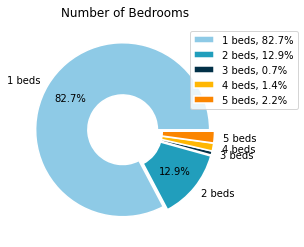

In [15]:
colors = ['#8ecae6', '#219ebc', '#023047', '#ffb703', '#fb8500']
explode = [0.03] * 5
labels = [str(s) + ' beds' for s in bedroom_labels]
wedgeprops = {'width': 0.6, 'edgecolor':'w', 'linewidth':1.5}
plt.pie(bedroom_values, labels=labels, colors=colors, autopct=custom_autopct, explode=explode, wedgeprops=wedgeprops, pctdistance=0.7)
plt.title("Number of Bedrooms")

bedroom_percent = (bedroom_values / total_bedrooms) * 100
legend_labels = [f'{l}, {s:0.1f}%' for l, s in zip(labels, bedroom_percent)]
plt.legend(loc=(0.8, 0.6), labels=legend_labels)

plt.savefig('Graphs/byBedroom.png', dpi=100)
plt.show()

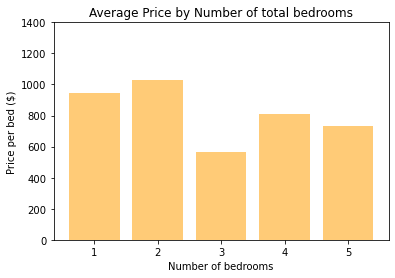

In [16]:
plt.bar(price_by_bedroom.keys(), price_by_bedroom.values(), color='#ffcb77')
plt.ylim(0, 1400)
plt.title("Average Price by Number of total bedrooms")
plt.xlabel('Number of bedrooms')
plt.ylabel('Price per bed ($)')
plt.savefig('Graphs/priceByBedroom.png', dpi=100)
plt.show()

In [17]:
searchCount = df[df['isLookingFor'] == True].shape[0]
offerCount = df[df['isLookingFor'] == False].shape[0]

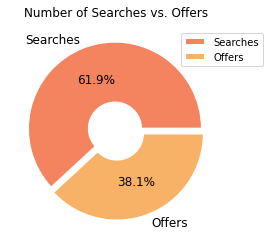

In [18]:
my_values = [searchCount, offerCount]
my_labels = ['Searches', 'Offers']
colors = ['#f4845f', '#f7b267']
explode = [0.03] * 2
wedgeprops = {'width': 0.7, 'edgecolor':'w', 'linewidth':2}
textprops = {"fontsize":12}
plt.pie(my_values, labels=my_labels, explode=explode, autopct = "%0.1f%%", colors=colors, wedgeprops=wedgeprops, textprops=textprops)
plt.title('Number of Searches vs. Offers', )
plt.legend(loc=(0.8, 0.8))
plt.savefig('Graphs/compare_searches_offers.png', dpi=100)
plt.show()

In [19]:
# a new dataframe to store average price, for Searches and Offers individually
avg_price = pd.DataFrame(bedroom_labels, columns=['bedroom'])

In [20]:
df_searches = df.groupby('isLookingFor').get_group(True).groupby('bedroom').mean()['price']
df_offers = df.groupby('isLookingFor').get_group(False).groupby('bedroom').mean()['price']

In [21]:
# min and max calculated to be used in the bar graph later (we want this here before inserting zeros)
min_price = min(list(df_searches) + list(df_offers))
max_price = max(list(df_searches) + list(df_offers))
min_price, max_price

(566.0, 1109.875)

In [22]:
avg_price['Searches'] = np.arange(5)
avg_price['Offers'] = np.arange(5)

for i, value in enumerate(bedroom_labels):
    if value in df_searches.index:
        avg_price.iloc[i, 1] = round(df_searches[value], 1)
    else: 
        avg_price.iloc[i, 1] = 0
        
    if value in df_offers.index:
        avg_price.iloc[i, 2] = round(df_offers[value], 1)
    else:
        avg_price.iloc[i, 2] = 0

In [23]:
avg_price

,bedroom,Searches,Offers
0,1,971.5,903.5
1,2,965.0,1109.9
2,3,566.0,0.0
3,4,825.0,800.0
4,5,765.0,675.0


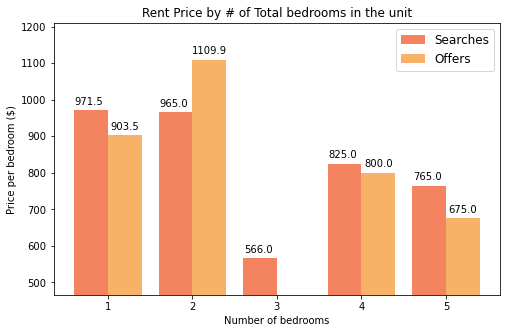

In [24]:
plt.figure(figsize=(8, 5))
plt.title('Rent Price by # of Total bedrooms in the unit')

searches_bar = plt.bar(bedroom_labels, avg_price['Searches'], width=-0.4, align='edge', label='Searches', color='#f4845f')
offers_bar = plt.bar(bedroom_labels, avg_price['Offers'], width=0.4, align='edge', label='Offers', color='#f7b267')

plt.ylim(min_price - 100, max_price + 100)
plt.legend(ncol=1, prop={'size': 12}, loc=1)
plt.savefig('Graphs/compare_price_searches_offers.png', dpi=100)
plt.xlabel('Number of bedrooms')
plt.ylabel('Price per bedroom ($)')

for idx, rect in enumerate(searches_bar): 
    if rect.get_height():
        plt.text(idx+0.78, rect.get_height() + 15, avg_price['Searches'][idx], ha='center', color='black')

for idx, rect in enumerate(offers_bar):
    if rect.get_height():
        plt.text(idx+1.2, rect.get_height() + 15, avg_price['Offers'][idx], ha='center', color='black')

plt.show()